In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score

In [20]:
TARGET = 'pred1'

## Read inputs

In [9]:
all_stock = pd.read_csv("data/all_stocks_5yr.csv")
cons = pd.read_csv("data/constituents.csv")
all_data = all_stock.merge(cons, left_on=['Name'], right_on = ['Symbol'], suffixes=('_x', '_company'))
all_data.reset_index(inplace=True, drop=True)

all_comp = list(all_data["Name_company"].unique())
all_df = []
for each_comp in all_comp:
    tmp = all_data.loc[all_data.Name_company == each_comp]
    tmp.loc[:, "yoy_perc"] = tmp.loc[:, "close"].pct_change(periods=365)
    tmp.loc[:, "dod_perc"] = tmp.loc[:, "close"].pct_change(periods=1)
    tmp.loc[:, "avg_dod_perc"] = tmp.loc[:, "dod_perc"].rolling(2).mean()
    tmp.loc[:, "avg_yoy_perc"] = tmp.loc[:, "yoy_perc"].rolling(365).mean()
    tmp.loc[:, "mom_perc"] = tmp.loc[:, "close"].pct_change(periods=30)
    tmp.loc[:, "avg_mom_perc"] = tmp.loc[:, "mom_perc"].rolling(30).mean()
    all_df.append(tmp)
all_data_mod = pd.concat(all_df, axis=0)

splitted = all_data_mod['date'].str.split('-', expand=True)

all_data_mod.loc[:, 'day'] = splitted[2].astype('int')
all_data_mod.loc[:, 'month'] = splitted[1].astype('int')
all_data_mod.loc[:, 'year'] = splitted[0].astype('int')

all_data_app = all_data_mod.loc[all_data_mod.Name_company == "Apple", :].sort_values("date", ascending=True)

splitted = all_data_app['date'].str.split('-', expand=True)
 
all_data_app['day'] = splitted[2].astype('int')
all_data_app['month'] = splitted[1].astype('int')
all_data_app['year'] = splitted[0].astype('int')

all_data_app['is_quarter_end'] = np.where(all_data_app['month']%3==0,1,0)
all_data_app['open-close']  = all_data_app['open'] - all_data_app['close']
all_data_app['low-high']  = all_data_app['low'] - all_data_app['high']

forecast_out = 1
#Create another column (the target ) shifted 'n' units up
all_data_app['pred1'] = all_data_app[['close']].shift(-1)
all_data_app['pred7'] = all_data_app[['close']].shift(-7)

weekly_trend = all_data_app.shift(1).rolling(7).sum()["pred1"]
all_data_app["weekly_trend1"] = weekly_trend

weekly_trend = all_data_app.shift(1).rolling(7).sum()["pred7"]
all_data_app["weekly_trend7"] = weekly_trend

weekly_mean = all_data_app.rolling(7).mean()["close"]
quarterly_mean = all_data_app.rolling(90).mean()["close"]
annual_mean = all_data_app.rolling(365).mean()["close"]

all_data_app["weekly_mean"] = weekly_mean / all_data_app["close"]
all_data_app["quarterly_mean"] = quarterly_mean / all_data_app["close"]
all_data_app["annual_mean"] = annual_mean / all_data_app["close"]

all_data_app["annual_weekly_mean"] = all_data_app["annual_mean"] / all_data_app["weekly_mean"]
all_data_app["annual_quarterly_mean"] = all_data_app["annual_mean"] / all_data_app["quarterly_mean"]

all_data_app["open_close_ratio"] = all_data_app["open"] / all_data_app["close"]
all_data_app["high_close_ratio"] = all_data_app["high"] / all_data_app["close"]
all_data_app["low_close_ratio"] = all_data_app["low"] / all_data_app["close"]

# Also calculate moving averages for features
all_data_app['ema50'] = all_data_app['close'] / all_data_app['close'].ewm(50).mean()
all_data_app['ema21'] = all_data_app['close'] / all_data_app['close'].ewm(21).mean()
all_data_app['ema15'] = all_data_app['close'] / all_data_app['close'].ewm(14).mean()
all_data_app['ema5'] = all_data_app['close'] / all_data_app['close'].ewm(5).mean()

# Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
all_data_app['normVol'] = all_data_app['volume'] / all_data_app['volume'].ewm(5).mean()
all_data_app = all_data_app.dropna()

all_data_app = all_data_app.drop(["Name_x", "Symbol", "Name_company", "Sector", "date"], axis=1)

features = ["yoy_perc", "dod_perc", "open", "high", "low", "close", "volume", "ema5", "ema15", "ema21", "ema50", "normVol", "weekly_mean", "quarterly_mean", "annual_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]
features += ['low-high', 'open-close', "is_quarter_end", "day", "month", "year"]
all_data_app

C:\Users\sunny\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\sunny\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,open,high,low,close,volume,yoy_perc,dod_perc,avg_dod_perc,avg_yoy_perc,mom_perc,...,annual_weekly_mean,annual_quarterly_mean,open_close_ratio,high_close_ratio,low_close_ratio,ema50,ema21,ema15,ema5,normVol
1988,107.010,107.030,104.82,105.26,40912316,0.111275,-0.019195,-0.016127,0.601531,-0.074149,...,1.073048,1.013548,1.016625,1.016816,0.995820,0.915056,0.933900,0.943469,0.971332,1.119811
1989,102.610,105.368,102.00,105.35,67649387,0.083959,0.000855,-0.009170,0.600577,-0.101799,...,1.075946,1.013585,0.973991,1.000171,0.968201,0.917352,0.937481,0.947797,0.976694,1.621481
1990,105.750,105.850,102.41,102.71,55790992,0.058539,-0.025059,-0.012102,0.599599,-0.135292,...,1.084622,1.014413,1.029598,1.030572,0.997079,0.896220,0.917576,0.928749,0.959862,1.266084
1991,100.560,102.370,99.87,100.70,68457388,0.031012,-0.019570,-0.022314,0.598421,-0.155909,...,1.095490,1.015699,0.998610,1.016584,0.991758,0.880777,0.903743,0.916035,0.950412,1.422312
1992,98.680,100.130,96.43,96.45,81094428,-0.025954,-0.042205,-0.030887,0.597023,-0.180892,...,1.111059,1.017314,1.023121,1.038154,0.999793,0.846199,0.870921,0.884605,0.924115,1.512252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,177.300,179.440,176.82,177.04,32689146,0.639259,0.000226,-0.003978,0.296472,0.045594,...,0.794249,0.845443,1.001469,1.013556,0.998757,1.058605,1.023036,1.014621,1.002567,1.146914
2507,177.250,177.300,173.20,174.22,51105090,0.614194,-0.015929,-0.007851,0.298609,0.028636,...,0.797110,0.845634,1.017392,1.017679,0.994145,1.040890,1.006432,0.998562,0.988806,1.583719
2508,174.505,174.950,170.53,171.11,41529004,0.581716,-0.017851,-0.016890,0.300637,-0.009035,...,0.801362,0.846034,1.019841,1.022442,0.996610,1.021863,0.988984,0.981998,0.975847,1.228220
2509,172.000,172.000,170.06,171.51,39143011,0.566588,0.002338,-0.007757,0.302556,-0.001107,...,0.807281,0.846328,1.002857,1.002857,0.991546,1.023765,0.991689,0.985325,0.981706,1.128015


In [10]:
sc_X = StandardScaler()
tmp =  pd.DataFrame(sc_X.fit_transform(all_data_app[features]), columns=features, index=all_data_app.index)

tmp = tmp.copy(deep=True)
all_data_app[features] = tmp[features]

## Train Test split

In [11]:
# Train test split
train = all_data_app.iloc[:-100]
test = all_data_app.iloc[-100:]
X_train = train.drop(["pred1"], axis=1)
X_test = test.drop(["pred1"], axis=1)

y_train, y_test = train.pred1, test.pred1

## Regression Models

In [48]:
from math import sqrt
mse_list=dict()

def model_fit(X_train, y_train, X_test, y_test, algo_name, algorithm, gridSearchParams, cv, imp_display):
    
    np.random.seed(10)
    
    grid = GridSearchCV(
        estimator=algorithm,
        param_grid=gridSearchParams,
        cv=cv,  verbose=1, n_jobs=-1)
    
    
    grid_result = grid.fit(X_train, y_train)
    best_params = grid_result.best_params_
    pred = grid_result.predict(X_test)
    
    label_list=y_test.tolist()
    

    print('Best Params :',best_params)
    print('Root Mean squared error {}'.format(sqrt(mean_squared_error(y_test, pred))))
    
    pred_test = grid_result.predict(X_test)
    diff = label_list - pred_test
    res_df = pd.concat([pd.Series(pred_test),pd.Series(label_list),pd.Series(diff)],axis=1)
    res_df.columns = [TARGET,'Original Data','Diff']
    print()
    print('******************** MSE BASED on ORIGINAL TEST DATA **************************')
    print('Root Mean squared error {}'.format(sqrt(mean_squared_error(label_list, pred_test))))
    print("Root Mean absolute error: {}".format(sqrt(mean_absolute_error(label_list,pred_test))))

    mse_list[algo_name]=sqrt(mean_squared_error(label_list, pred_test))
    print('******************** Prediction vs ORIGINAL TEST DATA **************************')
    print(res_df.head())
    
    if (algo_name == "randomforest") or (algo_name == "xgboost"):
        imp  = grid_result.best_estimator_.feature_importances_
    if (algo_name == "ridge") or (algo_name == "linear"):
        imp = grid_result.best_estimator_.coef_
        
    if imp_display:
        
        importances = pd.DataFrame(data={
        'Attribute': X_train.columns,
        'Importance': imp
        })

        importances = importances.sort_values(by='Importance', ascending=False)
        plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
        plt.title('Feature importances obtained from coefficients', size=20)
        plt.xticks(rotation='vertical')
        plt.show()
        
    return grid_result
    
    
    
pd.options.display.float_format = '{:.2f}'.format

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params : {'n_estimators': 100}
Root Mean squared error 9.219589920945538

******************** MSE BASED on ORIGINAL TEST DATA **************************
Root Mean squared error 9.219589920945538
Root Mean absolute error: 2.7430621575166727
******************** Prediction vs ORIGINAL TEST DATA **************************
   pred1  Original Data  Diff
0 161.41         161.26 -0.15
1 161.15         158.63 -2.52
2 160.20         161.50  1.30
3 161.72         160.86 -0.86
4 159.55         159.65  0.10


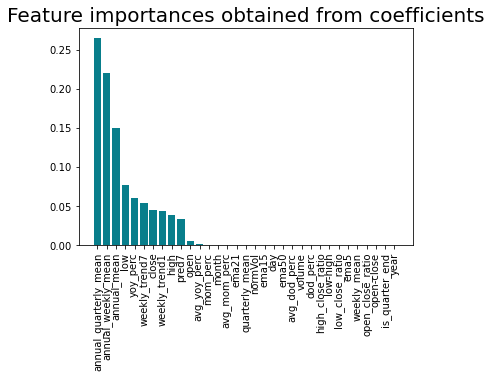

In [49]:
param ={
            'n_estimators': [100, 300, 500],
           
        }

best_model = model_fit(X_train, y_train, X_test, y_test, 'randomforest', RandomForestRegressor(), param, cv=5, imp_display=True)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params : {'alpha': 1}
Root Mean squared error 1.3308412727059546

******************** MSE BASED on ORIGINAL TEST DATA **************************
Root Mean squared error 1.3308412727059546
Root Mean absolute error: 1.051236602165411
******************** Prediction vs ORIGINAL TEST DATA **************************
   pred1  Original Data  Diff
0 161.00         161.26  0.26
1 160.81         158.63 -2.18
2 159.56         161.50  1.94
3 161.31         160.86 -0.45
4 160.16         159.65 -0.51


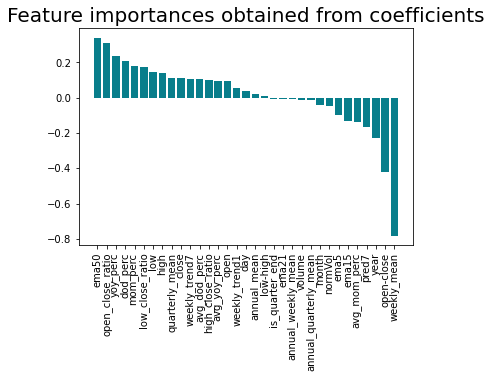

In [50]:
param ={
            'alpha': [0, 0.5, 1],
           
        }

best_model = model_fit(X_train, y_train, X_test, y_test, 'ridge', Ridge(), param, cv=5, imp_display=True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[19:32:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Params : {'max_depth': 8, 'n_estimators': 500}
Root Mean squared error 10.09327058877412

******************** MSE BASED on ORIGINAL TEST DATA **************************
Root Mean squared error 10.09327058877412
Root Mean absolute error: 2.8691217419817687
******************** Prediction vs ORIGINAL TEST DATA **************************
   pred1  Original Data  Diff
0 162.19         161.26 -0.93
1 161.50         158.63 -2.87
2 160.82         161.50  0.68
3 161.65         160.86 -0.79
4 158.56         159.65  1.09


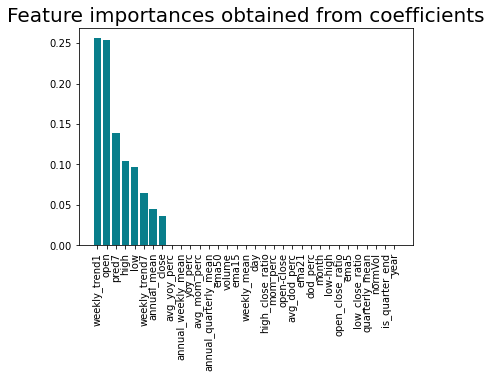

In [51]:
param ={
            'n_estimators': [100,200,500],
            'max_depth':[2,4,6,8]
        }

xgboost_tree = xgb.XGBRegressor(
    eta = 0.1,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)

best_model = model_fit(X_train, y_train, X_test, y_test,'xgboost', xgboost_tree, param, cv=5, imp_display=True)